# MacB Coarse Grain All Trajectory Analysis

## MD Analysis

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import statistics as s
import MDAnalysis as mda
#import nglview as nv

### Helper Modules

In [ ]:
# Converts 3 letter code to 1 letter code
convert_to_one_letter_dic = {"ALA":"A", "ARG":"R", "ASN":"N", "ASP":"D", "CYS":"C", "GLU":"E", "GLN":"Q", "GLY":"G",\
                            "HSD":"H", "HIS": "H", "HSE":"H", "ILE": "I", "LEU": "L", "LYS":"K", "MET":"M", "PHE":"F", "PRO":"P",\
                            "SER":"S", "THR":"T", "TRP":"W", "TYR":"Y", "VAL":"V"}
def convert_to_one_letter(string):
    amino_acid = str(string[0:3])
    return convert_to_one_letter_dic[amino_acid]

In [ ]:
# Permutation test function
def permutation(pooled,sizeA,sizeB,iterations):
    """
    Function takes pooled samples and randomly shuffles them according to partition size.
    New randommly shuffled partitions are sorted and substracted mean calculated (delta).
    Delta appended to a list. 
    Set x iterations.
    """
    count = 0
    mean_list = []
    while count < iterations:
        np.random.shuffle(pooled)
        new_A = pooled[:sizeA]
        new_B = pooled[-sizeB:]
        delta = s.mean(new_A) - s.mean(new_B)
        mean_list.append(delta)
        count += 1
    return mean_list

In [ ]:
def extract_sub_vals_clust(data):
    """
    Function takes a dataframe and returns internal lipid or no internal lipid average median count values.
    """
    internal_lip_vals = []
    no_internal_lip_vals = []
    for row in data.itertuples():
        if row.Internal_Lipid == 'yes':
            internal_lip_vals.append(row.Scaled_Median_Count)
        elif row.Internal_Lipid  == 'no':
            no_internal_lip_vals.append(row.Scaled_Median_Count)
                
    return internal_lip_vals, no_internal_lip_vals

In [ ]:
def clust_dic(dataframe):
    internal_lip_clust_dic = dict()
    no_internal_lip_clust_dic = dict()
    for row in dataframe.itertuples():
        if row.Internal_Lipid == "yes":
            internal_lip_clust_dic[(row.Domain,row.Lipid)] = row.avg
        elif row.Internal_Lipid == "no":
            no_internal_lip_clust_dic[(row.Domain,row.Lipid)] = row.avg
        
    return internal_lip_clust_dic, no_internal_lip_clust_dic

In [ ]:
def chain_pair_vals(chain_A,chain_B):
    """
    Function takes dictionary of chain values for chain A and B and returns the difference
    when the amino acids match. Else searches for instances where amino acid is unique to chain A or B.
    """
    A_B_diff = dict()
    unique_A = dict()
    unique_B = dict()
    for k1,v1 in chain_A.items():
        for k2,v2 in chain_B.items():
            if k1 == k2:
                diff = 0
                diff = v1 - v2
                A_B_diff[k1] = diff
            elif k1 not in chain_B.keys():
                unique_A[k1] = v1
    for k3,v3 in chain_B.items():
        if k3 not in chain_A.keys():
            unique_B[k3] = v3
    return A_B_diff, unique_A, unique_B

In [ ]:
def p_val(difference_dic,iterations,permute_results):
    results_array = np.array(permute_results)
    p_val_dict = dict()
    for v1, v2 in difference_dic.items():
        if v2 < 0:
            diffCount = len(np.where(np.sort(results_array) <= v2)[0])
            p_val = float(diffCount)/float(iterations)
            p_val_dict[v1] = p_val
        else:
            diffCount = len(np.where(np.sort(results_array) >= v2)[0])
            p_val = float(diffCount)/float(iterations)
            p_val_dict[v1] = p_val
    return p_val_dict

In [ ]:
def sig_p_val(p_val_dic,sig_level):
    num_tests = int(len(p_val_dic))
    bonferroni = sig_level/num_tests
    sig_vals = dict()
    for key,val in p_val_dic.items():
        if val <= bonferroni:
            sig_vals[key] = val
    return sig_vals

In [ ]:
def bootstrap_lipid(pooled,n_samples,iterations):
    random.seed(42) # set seed
    count = 0
    mean_diff_list = [] #store median difference values for plotting
    while count < iterations:
        # randomly select samples from the list without replacement
        # calculate mean difference - smoother distn than calc median diff
        np.random.shuffle(pooled) # first shuffle the data
        sample_1 = random.sample(pooled, n_samples)
        sample_2 = random.sample(pooled, n_samples)
        mean_diff = np.mean(sample_1) - np.mean(sample_2)
        mean_diff_list.append(mean_diff)
        count += 1
        
    return mean_diff_list

In [ ]:
def extract_pope_vals(data):
    """
    Function takes a dataframe and returns internal lipid or no internal lipid for 
    POPE values.
    """
    internal_lip_pope_vals = []
    no_internal_lip_pope_vals = []
    for row in data.itertuples():
        if row._2 == 'Yes':
            internal_lip_pope_vals.append(row.POPE)
        elif row._2 == 'No':
            no_internal_lip_pope_vals.append(row.POPE)
                
    return internal_lip_pope_vals, no_internal_lip_pope_vals

In [ ]:
def chain_dic_frames_pope(data):
    """
    Function takes a dataframe and returns internal lipd or no internal lipid interaction 
    values based on chainID.
    """
    internal_lip_dic = dict()
    no_internal_lip_dic = dict()
    for row in data.itertuples():
        if row._1 == "Yes":
            internal_lip_dic[(row.Chain,row.Joint_Position)] = row.Mean_POPE
        elif row._1 == "No":
            no_internal_lip_dic[(row.Chain,row.Joint_Position)] = row.Mean_POPE
                
    return internal_lip_dic, no_internal_lip_dic

In [ ]:
def chain_pair_vals(chain_A,chain_B):
    """
    Function takes dictionary of chain values for chain A and B and returns the difference
    when the amino acids match. Else searches for instances where amino acid is unique to chain A or B.
    """
    A_B_diff = dict()
    unique_A = dict()
    unique_B = dict()
    for k1,v1 in chain_A.items():
        for k2,v2 in chain_B.items():
            if k1 == k2:
                diff = 0
                diff = v1 - v2
                A_B_diff[k1] = diff
            elif k1 not in chain_B.keys():
                unique_A[k1] = v1
    for k3,v3 in chain_B.items():
        if k3 not in chain_A.keys():
            unique_B[k3] = v3
    return A_B_diff, unique_A, unique_B

In [ ]:
def extract_cdl2_vals(data):
    """
    Function takes a dataframe and returns internal lipid or no internal lipid for 
    CDL2 values.
    """
    internal_lip_cdl2_vals = []
    no_internal_lip_cdl2_vals = []
    for row in data.itertuples():
        if row._2 == 'Yes':
            internal_lip_cdl2_vals.append(row.CDL2)
        elif row._2 == 'No':
            no_internal_lip_cdl2_vals.append(row.CDL2)
                
    return internal_lip_cdl2_vals, no_internal_lip_cdl2_vals

In [ ]:
def chain_dic_frames_cdl2(data):
    """
    Function takes a dataframe and returns internal lipd or no internal lipid interaction 
    values based on chainID.
    """
    internal_lip_dic_cdl2 = dict()
    no_internal_lip_dic_cdl2 = dict()
    for row in data.itertuples():
        if row._1 == "Yes":
            internal_lip_dic_cdl2[(row.Chain,row.Joint_Position)] = row.Mean_CDL2
        elif row._1 == "No":
            no_internal_lip_dic_cdl2[(row.Chain,row.Joint_Position)] = row.Mean_CDL2
                
    return internal_lip_dic_cdl2, no_internal_lip_dic_cdl2

In [ ]:
def extract_popg_vals(data):
    """
    Function takes a dataframe and returns internal lipid or no internal lipid for 
    POPG values.
    """
    internal_lip_popg_vals = []
    no_internal_lip_popg_vals = []
    for row in data.itertuples():
        if row._2 == 'Yes':
            internal_lip_popg_vals.append(row.POPG)
        elif row._2 == 'No':
            no_internal_lip_popg_vals.append(row.POPG)
                
    return internal_lip_popg_vals, no_internal_lip_popg_vals

In [ ]:
def chain_dic_frames_popg(data):
    """
    Function takes a dataframe and returns internal lipd or no internal lipid interaction 
    values based on chainID.
    """
    internal_lip_dic_popg = dict()
    no_internal_lip_dic_popg = dict()
    for row in data.itertuples():
        if row._1 == "Yes":
            internal_lip_dic_popg[(row.Chain,row.Joint_Position)] = row.Mean_POPG
        elif row._1 == "No":
            no_internal_lip_dic_popg[(row.Chain,row.Joint_Position)] = row.Mean_POPG
                
    return internal_lip_dic_popg, no_internal_lip_dic_popg

### Plots for thesis - set colours

In [ ]:
palette = sns.color_palette("deep")

In [ ]:
blue = sns.color_palette("deep")[0]
orange = sns.color_palette("deep")[1]
green = sns.color_palette("deep")[2]
red = sns.color_palette("deep")[3]
purple = sns.color_palette("deep")[4]
brown = sns.color_palette("deep")[5]
pink = sns.color_palette("deep")[6]
grey = sns.color_palette("deep")[7]
gold = sns.color_palette("deep")[8]
turqoise = sns.color_palette("deep")[9]

### Define Universes

In [ ]:
# Read trajectory
u1 = mda.Universe("MacB_Internal_Lipid_Traj_1_nowater_chainAB.pdb", 'MacB_Internal_Lipid_Traj_1_nowater_skip1000.xtc')
u2 = mda.Universe("MacB_Internal_Lipid_Traj_2_nowater_chainAB.pdb", 'MacB_Internal_Lipid_Traj_2_nowater_skip1000.xtc')
u3 = mda.Universe("MacB_Internal_Lipid_Traj_3_nowater_chainAB.pdb", 'MacB_Internal_Lipid_Traj_3_nowater_skip1000.xtc')
u4 = mda.Universe("MacB_Internal_Lipid_Traj_4_nowater_chainAB.pdb", 'MacB_Internal_Lipid_Traj_4_nowater_skip1000.xtc')
u5 = mda.Universe("MacB_Internal_Lipid_Traj_5_nowater_chainAB.pdb", 'MacB_Internal_Lipid_Traj_5_nowater_skip1000.xtc')
u6 = mda.Universe("MacB_No_Internal_Lipid_Traj_1_nowater_chainAB.pdb", 'MacB_No_Internal_Lipid_Traj_1_nowater_skip1000.xtc')
u7 = mda.Universe("MacB_No_Internal_Lipid_Traj_2_nowater_chainAB.pdb", 'MacB_No_Internal_Lipid_Traj_2_nowater_skip1000.xtc')
u8 = mda.Universe("MacB_No_Internal_Lipid_Traj_3_nowater_chainAB.pdb", 'MacB_No_Internal_Lipid_Traj_3_nowater_skip1000.xtc')
u9 = mda.Universe("MacB_No_Internal_Lipid_Traj_4_nowater_chainAB.pdb", 'MacB_No_Internal_Lipid_Traj_4_nowater_skip1000.xtc')
u10 = mda.Universe("MacB_No_Internal_Lipid_Traj_5_nowater_chainAB.pdb", 'MacB_No_Internal_Lipid_Traj_5_nowater_skip1000.xtc')

In [ ]:
labels = ["u1","u2","u3","u4","u5","u6","u7","u8","u9","u10"]

In [ ]:
# Check length of the trajectories
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory), len(u4.trajectory), len(u5.trajectory))

In [ ]:
# Check length of the trajectories
print(len(u6.trajectory), len(u7.trajectory), len(u8.trajectory), len(u9.trajectory), len(u10.trajectory))

### Ensemble Cluster Analysis

This analysis only works with preselected atoms in trajectories. Only reduce number of frames to speed up calculation.

In [ ]:
# import modules
from MDAnalysis.analysis import encore
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm

In [ ]:
# Cluster
ces0, details0 = encore.ces(ensembles=[u1,u2,u3,u4,u5,u6,u7,u8,u9,u10], select="type B")

In [ ]:
# Print cluster info
cluster_collection = details0['clustering'][0]
print(type(cluster_collection))
print('We have found {} clusters'.format(len(cluster_collection)))

In [ ]:
# k-means clustering
km1 = clm.KMeans(80,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km2 = clm.KMeans(40,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km3 = clm.KMeans(20,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km4 = clm.KMeans(10,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default



In [ ]:
ces2, details2 = encore.ces([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10],
                         select='type B',
                         clustering_method=[km1, km2, km3, km4],
                         ncores=4)
print(len(ces2), len(details2['clustering']))

In [ ]:
# Plot clustering results
titles = ['Kmeans 80 clusters', 'Kmeans 40 clusters', 'Kmeans 20 clusters', 'Kmeans 10 clusters']
fig2, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
for i, (data, title) in enumerate(zip(ces2, titles)):
    imi = axes[i].imshow(data, vmax=np.log(2), vmin=0)
    axes[i].set_xticks(np.arange(10))
    axes[i].set_xticklabels(labels)
    axes[i].set_title(title)
plt.yticks(np.arange(10), labels)
cbar2 = fig2.colorbar(imi, ax=axes.ravel().tolist())
cbar2.set_label('Jensen-Shannon divergence')
plt.savefig("Ensemble Cluster K means All Trajectories 3.png", dpi = 300)

In [ ]:
#estimate errors
avgs, stds = encore.ces([u1, u2, u3, u4, u5, u6, u7, u8, u9, u10],
                         select='type B',
                         clustering_method=km4,
                         estimate_error=True,
                         ncores=4)

In [ ]:
avgs

In [ ]:
stds

## Protein Lipid Contacts

### Lipid Clustering Analysis

In [ ]:
# Data import with internal lipid - by domain only
# Combine temps as well & concat
lipid_clust_lip_traj_1 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_Internal_Lipid_Traj_1.csv")
lipid_clust_lip_traj_2 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_Internal_Lipid_Traj_2.csv")
lipid_clust_lip_traj_3 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_Internal_Lipid_Traj_3.csv")
lipid_clust_lip_traj_4 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_Internal_Lipid_Traj_4.csv")
lipid_clust_lip_traj_5 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_Internal_Lipid_Traj_5.csv")

In [ ]:
# Data import without internal lipid - by domain only
lipid_clust_nolip_traj_1 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_No_Internal_Lipid_Traj_1.csv")
lipid_clust_nolip_traj_2 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_No_Internal_Lipid_Traj_2.csv")
lipid_clust_nolip_traj_3 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_No_Internal_Lipid_Traj_3.csv")
lipid_clust_nolip_traj_4 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_No_Internal_Lipid_Traj_4.csv")
lipid_clust_nolip_traj_5 = pd.read_csv("data/Lipid_Clustering_Counts_scaled_No_Internal_Lipid_Traj_5.csv")

In [ ]:
# Data import with internal lipid - by chain and domain
lipid_clust_lip_traj_1_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_Internal_Lipid_Traj_1.csv")
lipid_clust_lip_traj_2_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_Internal_Lipid_Traj_2.csv")
lipid_clust_lip_traj_3_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_Internal_Lipid_Traj_3.csv")
lipid_clust_lip_traj_4_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_Internal_Lipid_Traj_4.csv")
lipid_clust_lip_traj_5_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_Internal_Lipid_Traj_5.csv")

In [ ]:
# Data import without internal lipid - by chain and domain
lipid_clust_nolip_traj_1_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_No_Internal_Lipid_Traj_1.csv")
lipid_clust_nolip_traj_2_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_No_Internal_Lipid_Traj_2.csv")
lipid_clust_nolip_traj_3_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_No_Internal_Lipid_Traj_3.csv")
lipid_clust_nolip_traj_4_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_No_Internal_Lipid_Traj_4.csv")
lipid_clust_nolip_traj_5_bychain = pd.read_csv("data/Lipid_Clustering_Counts_by_Chain_scaled_No_Internal_Lipid_Traj_5.csv")

In [ ]:
# Combine by presence of internal lipid
lipid_clust_internal_lipid = pd.concat([lipid_clust_lip_traj_1,lipid_clust_lip_traj_2,
                                       lipid_clust_lip_traj_3, lipid_clust_lip_traj_4,
                                       lipid_clust_lip_traj_5],ignore_index=True)
lipid_clust_no_internal_lipid = pd.concat([lipid_clust_nolip_traj_1,lipid_clust_nolip_traj_2,
                                       lipid_clust_nolip_traj_3, lipid_clust_nolip_traj_4,
                                       lipid_clust_nolip_traj_5],ignore_index=True)

In [ ]:
# Combine by presence of internal lipid - by chain
lipid_clust_internal_lipid_bychain = pd.concat([lipid_clust_lip_traj_1_bychain,
                                                lipid_clust_lip_traj_2_bychain,
                                                lipid_clust_lip_traj_3_bychain,
                                                lipid_clust_lip_traj_4_bychain,
                                                lipid_clust_lip_traj_5_bychain],
                                               ignore_index=True)
lipid_clust_no_internal_lipid_bychain = pd.concat([lipid_clust_nolip_traj_1_bychain,
                                                lipid_clust_nolip_traj_2_bychain,
                                                lipid_clust_nolip_traj_3_bychain,
                                                lipid_clust_nolip_traj_4_bychain,
                                                lipid_clust_nolip_traj_5_bychain],
                                               ignore_index=True)

In [ ]:
# Add in internal lipid info
lipid_clust_internal_lipid["Internal_Lipid"] = "yes"
lipid_clust_no_internal_lipid["Internal_Lipid"] = "no"

In [ ]:
# Add in internal lipid info - by chain
lipid_clust_internal_lipid_bychain["Internal_Lipid"] = "yes"
lipid_clust_no_internal_lipid_bychain["Internal_Lipid"] = "no"

In [ ]:
# Concat internal lipid and no internal lipid for plotting
lipid_clust = pd.concat([lipid_clust_internal_lipid,lipid_clust_no_internal_lipid])

In [ ]:
# Concat internal lipid and no internal lipid for plotting - by chain
lipid_clust_bychain = pd.concat([lipid_clust_internal_lipid_bychain,
                                 lipid_clust_no_internal_lipid_bychain])

In [ ]:
# Add label for seaborn plot
lipid_clust["Label"] = lipid_clust["Lipid"].astype(str) + " " + lipid_clust["Internal_Lipid"].astype(str)

In [ ]:
# Add label for seaborn plot - by chain
lipid_clust_bychain["Label"] = lipid_clust_bychain["Lipid"].astype(str) + " " + lipid_clust_bychain["Internal_Lipid"].astype(str)

#### Plots

In [ ]:
fig_dims = (20, 5)
fig, ax = plt.subplots(figsize=fig_dims)
clust_fig_label = sns.barplot(data=lipid_clust, x='Domain', y='Scaled_Median_Count', hue='Label',
                              estimator=np.mean,ci=90, order=["Periplasmic Domain", "TM1", "TM2", "NBD"]).get_figure();
clust_fig_label.savefig("Lipid Clustering", dpi=300)

In [ ]:
fig_dims = (20, 5)
fig, ax = plt.subplots(figsize=fig_dims)
clust_fig = sns.barplot(data=lipid_clust, x='Domain', y='Scaled_Median_Count', 
                        hue='Internal_Lipid',estimator=np.mean,ci=90,
                       order=["Periplasmic Domain", "TM1", "TM2", "NBD"]).get_figure();
clust_fig.savefig("Lipid Clustering by internal lipid", dpi=300)

In [ ]:
fig_dims = (25, 5)
fig, ax = plt.subplots(figsize=fig_dims)
clust_fig_bychain = sns.barplot(data=lipid_clust_bychain, x='Domain', 
                                y='Scaled_Median_Count', hue='Label',
                                estimator=np.mean,ci=90,
                               order=["Chain A Periplasmic Domain", 
                                      "Chain B Periplasmic Domain","Chain A TM1", 
                                      "Chain B TM1","Chain A TM2", "Chain B TM2",
                                      "Chain A NBD", "Chain B NBD"]).get_figure();
clust_fig_bychain.savefig("Lipid Clustering by internal lipid and chain", dpi=300)

In [ ]:
fig_dims = (25, 5)
fig, ax = plt.subplots(figsize=fig_dims)
clust_fig_bychain_label = sns.barplot(data=lipid_clust_bychain, x='Domain', 
                                      y='Scaled_Median_Count', hue='Internal_Lipid',
                                      estimator=np.mean,ci=90,
                                      order=["Chain A Periplasmic Domain", 
                                      "Chain B Periplasmic Domain","Chain A TM1", 
                                      "Chain B TM1","Chain A TM2", "Chain B TM2",
                                      "Chain A NBD", "Chain B NBD"]).get_figure();
clust_fig_bychain_label.savefig("Lipid Clustering by chain", dpi=300)

### Significance Tests for Lipid Clustering

Test permutation test against my data & see differences in the output distributions.

In [ ]:
# Extract data by chain
perm_internal_clust, perm_nointernal_clust = extract_sub_vals_clust(lipid_clust_bychain)

In [ ]:
#Get permutation test distribution for substrate vs no substrate lipid clustering
pooled = np.hstack([perm_internal_clust,perm_nointernal_clust])
sizeA = 102
sizeB= 84
iterations = 1000000
test = permutation(pooled,sizeA,sizeB,iterations)

In [ ]:
#Plot permutation test histogram
plt.hist(test,bins=100);
plt.title("Permutation Test Internal Lipid")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Permutation Test Internal Lipid Lipid Clustering", dpi=150)

In [ ]:
# aggregate medians for permutation test
lipid_clust_sub_bychain_agg = lipid_clust_bychain.groupby(["Domain","Lipid","Internal_Lipid"]).agg(avg=('Scaled_Median_Count','mean'), std=('Scaled_Median_Count','std'))

In [ ]:
# reset index
lipid_clust_sub_bychain_agg.reset_index(inplace=True)

In [ ]:
# create dictionary of values
internal_lipid_clust_dic, no_internal_lipid_clust_dic = clust_dic(lipid_clust_sub_bychain_agg)

In [ ]:
# calculate differences in lipid clustering values
diff_lipid_clust, unique_lipid, unique_nolipid = chain_pair_vals(internal_lipid_clust_dic,no_internal_lipid_clust_dic)

In [ ]:
#Combine all three dicts to one dictionary
total_diff_sub_dic = {**diff_lipid_clust,**unique_lipid}

In [ ]:
#Calculate p-values using permutation test distribution
p_val_clust_perm = p_val(total_diff_sub_dic,iterations,test)

In [ ]:
#Convert p-values to series for saving
p_val_clust_perm_series = pd.Series(p_val_clust_perm, name='uncorrected p-value')
p_val_clust_perm_series.index.name = "Domain"
p_val_clust_perm_series.reset_index()

In [ ]:
#save p-values!
p_val_clust_perm_series.to_csv('Lipid clustering permutation p-values.csv')

In [ ]:
#Filter for significant p-values
perm_clust_p_val_sig = sig_p_val(p_val_clust_perm,0.05)

3 regions which show significant differences (5% sig level) when internal lipid is present & not present based on the permutation test (p-vals are corrected):

Chain A TM1: POPE --> p-val 9.8e-05\
Chain A Periplasmic Domain: POPE --> p-val 1e-06\
Chain B Periplasmic Domain: POPE --> p-val 0.00014

### Membrane Enrichment

In [ ]:
# Reimport all contacts for plotting - with internal lipid
cdl2_lipid_traj_1 = pd.read_csv("data/CDL2_Band_Enrichment_Internal_Lipid_Traj_1.csv")
cdl2_lipid_traj_2 = pd.read_csv("data/CDL2_Band_Enrichment_Internal_Lipid_Traj_2.csv")
cdl2_lipid_traj_3 = pd.read_csv("data/CDL2_Band_Enrichment_Internal_Lipid_Traj_3.csv")
cdl2_lipid_traj_4 = pd.read_csv("data/CDL2_Band_Enrichment_Internal_Lipid_Traj_4.csv")
cdl2_lipid_traj_5 = pd.read_csv("data/CDL2_Band_Enrichment_Internal_Lipid_Traj_5.csv")
pope_lipid_traj_1 = pd.read_csv("data/POPE_Band_Enrichment_Internal_Lipid_Traj_1.csv")
pope_lipid_traj_2 = pd.read_csv("data/POPE_Band_Enrichment_Internal_Lipid_Traj_2.csv")
pope_lipid_traj_3 = pd.read_csv("data/POPE_Band_Enrichment_Internal_Lipid_Traj_3.csv")
pope_lipid_traj_4 = pd.read_csv("data/POPE_Band_Enrichment_Internal_Lipid_Traj_4.csv")
pope_lipid_traj_5 = pd.read_csv("data/POPE_Band_Enrichment_Internal_Lipid_Traj_5.csv")
popg_lipid_traj_1 = pd.read_csv("data/POPG_Band_Enrichment_Internal_Lipid_Traj_1.csv")
popg_lipid_traj_2 = pd.read_csv("data/POPG_Band_Enrichment_Internal_Lipid_Traj_2.csv")
popg_lipid_traj_3 = pd.read_csv("data/POPG_Band_Enrichment_Internal_Lipid_Traj_3.csv")
popg_lipid_traj_4 = pd.read_csv("data/POPG_Band_Enrichment_Internal_Lipid_Traj_4.csv")
popg_lipid_traj_5 = pd.read_csv("data/POPG_Band_Enrichment_Internal_Lipid_Traj_5.csv")

In [ ]:
# Reimport all contacts for plotting - without internal lipid
cdl2_nolipid_traj_1 = pd.read_csv("data/CDL2_Band_Enrichment_No_Internal_Lipid_Traj_1.csv")
cdl2_nolipid_traj_2 = pd.read_csv("data/CDL2_Band_Enrichment_No_Internal_Lipid_Traj_2.csv")
cdl2_nolipid_traj_3 = pd.read_csv("data/CDL2_Band_Enrichment_No_Internal_Lipid_Traj_3.csv")
cdl2_nolipid_traj_4 = pd.read_csv("data/CDL2_Band_Enrichment_No_Internal_Lipid_Traj_4.csv")
cdl2_nolipid_traj_5 = pd.read_csv("data/CDL2_Band_Enrichment_No_Internal_Lipid_Traj_5.csv")
pope_nolipid_traj_1 = pd.read_csv("data/POPE_Band_Enrichment_No_Internal_Lipid_Traj_1.csv")
pope_nolipid_traj_2 = pd.read_csv("data/POPE_Band_Enrichment_No_Internal_Lipid_Traj_2.csv")
pope_nolipid_traj_3 = pd.read_csv("data/POPE_Band_Enrichment_No_Internal_Lipid_Traj_3.csv")
pope_nolipid_traj_4 = pd.read_csv("data/POPE_Band_Enrichment_No_Internal_Lipid_Traj_4.csv")
pope_nolipid_traj_5 = pd.read_csv("data/POPE_Band_Enrichment_No_Internal_Lipid_Traj_5.csv")
popg_nolipid_traj_1 = pd.read_csv("data/POPG_Band_Enrichment_No_Internal_Lipid_Traj_1.csv")
popg_nolipid_traj_2 = pd.read_csv("data/POPG_Band_Enrichment_No_Internal_Lipid_Traj_2.csv")
popg_nolipid_traj_3 = pd.read_csv("data/POPG_Band_Enrichment_No_Internal_Lipid_Traj_3.csv")
popg_nolipid_traj_4 = pd.read_csv("data/POPG_Band_Enrichment_No_Internal_Lipid_Traj_4.csv")
popg_nolipid_traj_5 = pd.read_csv("data/POPG_Band_Enrichment_No_Internal_Lipid_Traj_5.csv")

In [ ]:
# Concat trajectory repeats - by internal lipid
cdl2_lipid = pd.concat([cdl2_lipid_traj_1,cdl2_lipid_traj_2,cdl2_lipid_traj_3,
                       cdl2_lipid_traj_4,cdl2_lipid_traj_5]).groupby('Band Distance').agg(avg=('Enrichment_Score','mean'), std=('Enrichment_Score','std'))
pope_lipid = pd.concat([pope_lipid_traj_1,pope_lipid_traj_2,pope_lipid_traj_3,
                       pope_lipid_traj_4,pope_lipid_traj_5]).groupby('Band Distance').agg(avg=('Enrichment_Score','mean'), std=('Enrichment_Score','std'))
popg_lipid = pd.concat([popg_lipid_traj_1,popg_lipid_traj_2,popg_lipid_traj_3,
                       popg_lipid_traj_4,popg_lipid_traj_5]).groupby('Band Distance').agg(avg=('Enrichment_Score','mean'), std=('Enrichment_Score','std'))

In [ ]:
# Concat trajectory repeats - by no internal lipid
cdl2_nolipid = pd.concat([cdl2_nolipid_traj_1,cdl2_nolipid_traj_2,cdl2_nolipid_traj_3,
                       cdl2_nolipid_traj_4,cdl2_nolipid_traj_5]).groupby('Band Distance').agg(avg=('Enrichment_Score','mean'), std=('Enrichment_Score','std'))
pope_nolipid = pd.concat([pope_nolipid_traj_1,pope_nolipid_traj_2,pope_nolipid_traj_3,
                       pope_nolipid_traj_4,pope_nolipid_traj_5]).groupby('Band Distance').agg(avg=('Enrichment_Score','mean'), std=('Enrichment_Score','std'))
popg_nolipid = pd.concat([popg_nolipid_traj_1,popg_nolipid_traj_2,popg_nolipid_traj_3,
                       popg_nolipid_traj_4,popg_nolipid_traj_5]).groupby('Band Distance').agg(avg=('Enrichment_Score','mean'), std=('Enrichment_Score','std'))

In [ ]:
#Reset index to remove multi-indexing - internal lipid
cdl2_lipid.reset_index(inplace = True)
pope_lipid.reset_index(inplace = True)
popg_lipid.reset_index(inplace = True)

In [ ]:
#Reset index to remove multi-indexing - no internal lipid
cdl2_nolipid.reset_index(inplace = True)
pope_nolipid.reset_index(inplace = True)
popg_nolipid.reset_index(inplace = True)

In [ ]:
# Plot internal lipid vs no internal lipid
plt.errorbar(x=cdl2_lipid["Band Distance"],y=cdl2_lipid["avg"],yerr=cdl2_lipid["std"],xerr=2.5,label="CDL2 Internal Lipid")
plt.errorbar(x=cdl2_nolipid["Band Distance"],y=cdl2_nolipid["avg"],yerr=cdl2_nolipid["std"],xerr=2.5,label="CDL2 No Internal Lipid")
plt.errorbar(x=pope_lipid["Band Distance"],y=pope_lipid["avg"],yerr=pope_lipid["std"],xerr=2.5,label="POPE Internal Lipid")
plt.errorbar(x=pope_nolipid["Band Distance"],y=pope_nolipid["avg"],yerr=pope_nolipid["std"],xerr=2.5,label="POPE No Internal Lipid")
plt.errorbar(x=popg_lipid["Band Distance"],y=popg_lipid["avg"],yerr=popg_lipid["std"],xerr=2.5,label="POPG Internal Lipid")
plt.errorbar(x=popg_nolipid["Band Distance"],y=popg_nolipid["avg"],yerr=popg_nolipid["std"],xerr=2.5,label="POPG No Internal Lipid")
plt.legend(loc='best')
plt.title("Lipid Enrichment")
plt.xlabel("Radial Distance From Protein (Angstrom)")
plt.ylabel("Enrichment")
plt.savefig("Lipid Enrichment Internal Lipid vs No Internal Lipid", dpi=300)

In [ ]:
# Plot internal lipid
plt.errorbar(x=cdl2_lipid["Band Distance"],y=cdl2_lipid["avg"],yerr=cdl2_lipid["std"],xerr=2.5,label="CDL2")
plt.errorbar(x=pope_lipid["Band Distance"],y=pope_lipid["avg"],yerr=pope_lipid["std"],xerr=2.5,label="POPE")
plt.errorbar(x=popg_lipid["Band Distance"],y=popg_lipid["avg"],yerr=popg_lipid["std"],xerr=2.5,label="POPG")
plt.legend(loc='best')
plt.title("Lipid Enrichment Internal Lipid")
plt.xlabel("Radial Distance From Protein (Angstrom)")
plt.ylabel("Enrichment")
plt.savefig("Lipid Enrichment Internal Lipid", dpi=300)

In [ ]:
# Plot no internal lipid
plt.errorbar(x=cdl2_nolipid["Band Distance"],y=cdl2_nolipid["avg"],yerr=cdl2_nolipid["std"],xerr=2.5,label="CDL2")
plt.errorbar(x=pope_nolipid["Band Distance"],y=pope_nolipid["avg"],yerr=pope_nolipid["std"],xerr=2.5,label="POPE")
plt.errorbar(x=popg_nolipid["Band Distance"],y=popg_nolipid["avg"],yerr=popg_nolipid["std"],xerr=2.5,label="POPG")
plt.legend(loc='best')
plt.title("Lipid Enrichment No Internal Lipid")
plt.xlabel("Radial Distance From Protein (Angstrom)")
plt.ylabel("Enrichment")
plt.savefig("Lipid Enrichment No Internal Lipid", dpi=300)

## Protein Lipid Interactions

##### Raw Data

In [3]:
# Read in csv's
df_1 = pd.read_csv("data/protein_lipid_interaction_internal_lipid_traj_1.csv")
df_2 = pd.read_csv("data/protein_lipid_interaction_internal_lipid_traj_2.csv")
df_3 = pd.read_csv("data/protein_lipid_interaction_internal_lipid_traj_3.csv")
df_4 = pd.read_csv("data/protein_lipid_interaction_internal_lipid_traj_4.csv")
df_5 = pd.read_csv("data/protein_lipid_interaction_internal_lipid_traj_5.csv")
df_6 = pd.read_csv("data/protein_lipid_interaction_no_internal_lipid_traj_1.csv")
df_7 = pd.read_csv("data/protein_lipid_interaction_no_internal_lipid_traj_2.csv")
df_8 = pd.read_csv("data/protein_lipid_interaction_no_internal_lipid_traj_3.csv")
df_9 = pd.read_csv("data/protein_lipid_interaction_no_internal_lipid_traj_4.csv")
df_10 = pd.read_csv("data/protein_lipid_interaction_no_internal_lipid_traj_5.csv")

#### Combine Data

In [4]:
frames = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10]
combined_df = pd.concat(frames, ignore_index=True)

In [5]:
#Add one letter code back in
combined_df["Protein_Code"] = combined_df["Protein_Type"].apply(convert_to_one_letter)

In [6]:
combined_df["Joint_Position"] = combined_df["Protein_Code"].astype(str) + combined_df["Protein_ResID"].astype(str)

In [7]:
# First group by ID to sum appropriate lipid values
group_contact = combined_df.groupby(["ID","Internal_Lipid?","Chain","Protein_ResID","Joint_Position", "Lipid_Type"])["Fraction_Frames"].sum().unstack()

In [8]:
#Reset index to remove multi-indexing
group_contact.reset_index(inplace = True)

In [ ]:
#Fill in NaNs with 0s
group_contact["CDL2"].fillna(value = 0, inplace = True)
group_contact["POPE"].fillna(value = 0, inplace = True)
group_contact["POPG"].fillna(value = 0, inplace = True)

In [9]:
#sort values by protein position
group_contact.sort_values("Protein_ResID", axis = 0, ascending = True, inplace = True) 

In [10]:
# Add in sub columns for plotting
group_contact["Lipid_Count"] = group_contact["CDL2"] + group_contact["POPE"] + group_contact["POPG"]
group_contact["Internal_Lipid?_Chain"] = group_contact["Internal_Lipid?"].astype(str) + "_" + group_contact["Chain"].astype(str)

##### Exploratory Plots

In [13]:
palette_dic = {"Yes_A":blue, "No_A":orange,"Yes_B":green,"No_B":red}

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "Lipid_Count", 
                                    hue = "Internal_Lipid?_Chain", data = group_contact, 
                                    estimator=np.mean, ci=90, palette=palette_dic,
                                    hue_order=["Yes_A","No_A","Yes_B","No_B"],ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid and Chain.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "Lipid_Count", 
                                    hue = "Internal_Lipid?", data = group_contact, 
                                    estimator=np.mean, ci=90,ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "CDL2", 
                                    hue = "Internal_Lipid?_Chain", data = group_contact, 
                                    estimator=np.mean, ci=90, palette=palette_dic,
                                    hue_order=["Yes_A","No_A","Yes_B","No_B"],ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid and Chain CDL2.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "CDL2", 
                                    hue = "Internal_Lipid?", data = group_contact, 
                                    estimator=np.mean, ci=90,ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid CDL2.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "POPE", 
                                    hue = "Internal_Lipid?_Chain", data = group_contact, 
                                    estimator=np.mean, ci=90, palette=palette_dic,
                                    hue_order=["Yes_A","No_A","Yes_B","No_B"],ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid and Chain POPE.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "POPE", 
                                    hue = "Internal_Lipid?", data = group_contact, 
                                    estimator=np.mean, ci=90,ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid POPE.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "POPG", 
                                    hue = "Internal_Lipid?_Chain", data = group_contact, 
                                    estimator=np.mean, ci=90, palette=palette_dic,
                                    hue_order=["Yes_A","No_A","Yes_B","No_B"],ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid and Chain POPG.png", dpi = 300)

In [ ]:
fig_dims = (60, 10)
fig, ax = plt.subplots(figsize=fig_dims)
group_contact_lip_fig = sns.barplot(x = "Joint_Position", y = "POPG", 
                                    hue = "Internal_Lipid?", data = group_contact, 
                                    estimator=np.mean, ci=90,ax=ax).get_figure();
group_contact_lip_fig.savefig("Lipid Count Internal Lipid POPG.png", dpi = 300)

Some interesting differences between certain amino acids with POPE lipid - interesting to test.

### Plotting for Thesis Figures

##### POPE

In [ ]:
# Aggregate data - only separate by presence of substrate
group_contact_pope_lipid = group_contact.groupby(["ID","Internal_Lipid?","Chain","Protein_ResID","Joint_Position"])["POPE"].mean().unstack()

In [ ]:
#Reset index to remove multi-indexing
group_contact_pope_lipid.reset_index(inplace = True)

In [ ]:
# remove extra headers
head_list_pope_lipid = group_contact_pope_lipid.columns.tolist()
head_list_pope_lipid.remove('ID')
head_list_pope_lipid.remove('Internal_Lipid?')
head_list_pope_lipid.remove('Chain')
head_list_pope_lipid.remove('Protein_ResID')

In [ ]:
# Apply melt
melt_group_contact_pope = group_contact_pope_lipid.melt(id_vars=['ID','Internal_Lipid?','Chain','Protein_ResID'],value_vars=head_list_pope_lipid,value_name="Mean_POPE_Count")

In [ ]:
#remove nan values
melt_group_contact_pope.dropna(inplace = True)

In [ ]:
#sort values by protein position
melt_group_contact_pope.sort_values(["Protein_ResID","Chain"], axis = 0, ascending = True, inplace = True)

In [ ]:
# Add label
melt_group_contact_pope["Internal_Lipid?_Chain"] = melt_group_contact_pope["Internal_Lipid?"].astype(str) + "_" +  melt_group_contact_pope["Chain"].astype(str)

Plotting when small values are removed will result in an incorrect plot. We will first define the positions which contain significantly large values, and remove others from the original "melt_group_contact_{lipid}" dataframe.

In [ ]:
# Remove small values
melt_group_contact_pope_remove = melt_group_contact_pope[melt_group_contact_pope["Mean_POPE_Count"]>0.01]

In [ ]:
# Define dictionary to store positions with significant pope contacts
x_axis_headers_pope = []
for row in melt_group_contact_pope_remove.itertuples():
    if row.Joint_Position not in x_axis_headers_pope:
        x_axis_headers_pope.append(row.Joint_Position)

In [ ]:
# Use these to make a new dataframe - pope
pope_ID_list = []
pope_internal_lip_list = []
pope_chain_list = []
pope_resid_list = []
pope_joint_position_list = []
pope_list = []
pope_label_list = []

In [ ]:
# Loop over original dataframe and extract data from positions with significant pope contacts
for row in melt_group_contact_pope.itertuples():
    if row.Joint_Position in x_axis_headers_pope:
        pope_ID_list.append(row.ID)
        pope_internal_lip_list.append(row._2)
        pope_chain_list.append(row.Chain)
        pope_resid_list.append(row.Protein_ResID)
        pope_joint_position_list.append(row.Joint_Position)
        pope_list.append(row.Mean_POPE_Count)
        pope_label_list.append(row._7)

In [ ]:
# Make a dictionary of the lists with column headings - pope
data_pope = {'ID':pope_ID_list, 'Internal_Lipid?':pope_internal_lip_list,'Chain':pope_chain_list,
        'Protein_ResID':pope_resid_list,'Joint_Position':pope_joint_position_list,
        'Mean_POPE_Count':pope_list, 'Internal_Lipid?_Chain':pope_label_list}

In [ ]:
# Use dictionaries to make new dataframes - pope
pope_new = pd.DataFrame.from_dict(data_pope)

In [ ]:
# Plot using seaborn
fig_dims = (40, 10)
fig, ax = plt.subplots(figsize=fig_dims)
melt_group_contact_popeg_fig = sns.barplot(x = "Joint_Position", y = "Mean_POPE_Count", 
                                           hue = "Internal_Lipid?_Chain", 
                                           hue_order=["Yes_A","No_A","Yes_B","No_B"], 
                                           data = pope_new, palette=palette_dic, 
                                           estimator=np.mean,ci=90, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("POPE Fraction Frames")
plt.legend(loc='upper left');
melt_group_contact_popeg_fig.savefig("Mean POPE Count by Substrate and Chain Relabel Remove.png", dpi = 300)

##### CDL2

In [ ]:
# Aggregate data - only separate by presence of internal lipid
group_contact_cdl2_lipid = group_contact.groupby(["ID","Internal_Lipid?","Chain","Protein_ResID","Joint_Position"])["CDL2"].mean().unstack()

In [ ]:
#Reset index to remove multi-indexing
group_contact_cdl2_lipid.reset_index(inplace = True)

In [ ]:
# remove extra headers
head_list_cdl2_lipid = group_contact_cdl2_lipid.columns.tolist()
head_list_cdl2_lipid.remove('ID')
head_list_cdl2_lipid.remove('Internal_Lipid?')
head_list_cdl2_lipid.remove('Chain')
head_list_cdl2_lipid.remove('Protein_ResID')

In [ ]:
# Apply melt
melt_group_contact_cdl2 = group_contact_cdl2_lipid.melt(id_vars=['ID','Internal_Lipid?','Chain','Protein_ResID'],value_vars=head_list_cdl2_lipid,value_name="Mean_CDL2_Count")

In [ ]:
#remove nan values
melt_group_contact_cdl2.dropna(inplace = True)

In [ ]:
#sort values by protein position
melt_group_contact_cdl2.sort_values(["Protein_ResID","Chain"], axis = 0, ascending = True, inplace = True) 

In [ ]:
# Add label
melt_group_contact_cdl2["Internal_Lipid?_Chain"] = melt_group_contact_cdl2["Internal_Lipid?"].astype(str) + "_" +  melt_group_contact_cdl2["Chain"].astype(str)

In [ ]:
# Remove small values
melt_group_contact_cdl2_remove = melt_group_contact_cdl2[melt_group_contact_cdl2["Mean_CDL2_Count"]>0.01]

In [ ]:
# Define dictionary to store positions with significant cdl2 contacts
x_axis_headers_cdl2 = []
for row in melt_group_contact_cdl2_remove.itertuples():
    if row.Joint_Position not in x_axis_headers_cdl2:
        x_axis_headers_cdl2.append(row.Joint_Position)

In [ ]:
# Use these to make a new dataframe - cdl2
cdl2_ID_list = []
cdl2_internal_lip_list = []
cdl2_chain_list = []
cdl2_resid_list = []
cdl2_joint_position_list = []
cdl2_list = []
cdl2_label_list = []

In [ ]:
# Define dictionary to store positions with significant cdl2 contacts
for row in melt_group_contact_cdl2.itertuples():
    if row.Joint_Position in x_axis_headers_cdl2:
        cdl2_ID_list.append(row.ID)
        cdl2_internal_lip_list.append(row._2)
        cdl2_chain_list.append(row.Chain)
        cdl2_resid_list.append(row.Protein_ResID)
        cdl2_joint_position_list.append(row.Joint_Position)
        cdl2_list.append(row.Mean_CDL2_Count)
        cdl2_label_list.append(row._7)

In [ ]:
# Make a dictionary of the lists with column headings - cdl2
data_cdl2 = {'ID':cdl2_ID_list, 'Internal_Lipid?':cdl2_internal_lip_list,'Chain':cdl2_chain_list,
        'Protein_ResID':cdl2_resid_list,'Joint_Position':cdl2_joint_position_list,
        'Mean_CDL2_Count':cdl2_list, 'Internal_Lipid?_Chain':cdl2_label_list}

In [ ]:
# Use dictionaries to make new dataframes - cdl2
cdl2_new = pd.DataFrame.from_dict(data_cdl2)

In [ ]:
# Plot using seaborn
fig_dims = (40, 10)
fig, ax = plt.subplots(figsize=fig_dims)
melt_group_contact_cdl2_fig = sns.barplot(x = "Joint_Position", y = "Mean_CDL2_Count", 
                                           hue = "Internal_Lipid?_Chain", 
                                           hue_order=["Yes_A","No_A","Yes_B","No_B"], 
                                           data = cdl2_new, palette=palette_dic, 
                                           estimator=np.mean,ci=90, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("CDL2 Fraction Frames")
plt.legend(loc='upper left');
melt_group_contact_cdl2_fig.savefig("Mean CDL2 Count by Internal Lipid and Chain Relabel Remove.png", dpi = 300)

##### POPG

In [14]:
# Aggregate data - only separate by presence of internal lipid
group_contact_popg_lipid = group_contact.groupby(["ID","Internal_Lipid?","Chain","Protein_ResID","Joint_Position"])["POPG"].mean().unstack()

In [15]:
#Reset index to remove multi-indexing
group_contact_popg_lipid.reset_index(inplace = True)

In [16]:
# remove extra headers
head_list_popg_lipid = group_contact_popg_lipid.columns.tolist()
head_list_popg_lipid.remove('ID')
head_list_popg_lipid.remove('Internal_Lipid?')
head_list_popg_lipid.remove('Chain')
head_list_popg_lipid.remove('Protein_ResID')

In [17]:
# Apply melt
melt_group_contact_popg = group_contact_popg_lipid.melt(id_vars=['ID','Internal_Lipid?','Chain','Protein_ResID'],value_vars=head_list_popg_lipid,value_name="Mean_POPG_Count")

In [18]:
#remove nan values
melt_group_contact_popg.dropna(inplace = True)

In [19]:
#sort values by protein position
melt_group_contact_popg.sort_values(["Protein_ResID","Chain"], axis = 0, ascending = True, inplace = True) 

In [20]:
# Add label
melt_group_contact_popg["Internal_Lipid?_Chain"] = melt_group_contact_popg["Internal_Lipid?"].astype(str) + "_" +  melt_group_contact_popg["Chain"].astype(str)

In [21]:
# Remove small values
melt_group_contact_popg_remove = melt_group_contact_popg[melt_group_contact_popg["Mean_POPG_Count"]>0.01]

In [22]:
# Define dictionary to store positions with significant popg contacts
x_axis_headers_popg = []
for row in melt_group_contact_popg_remove.itertuples():
    if row.Joint_Position not in x_axis_headers_popg:
        x_axis_headers_popg.append(row.Joint_Position)

In [23]:
# Use these to make a new dataframe - popg
popg_ID_list = []
popg_internal_lip_list = []
popg_chain_list = []
popg_resid_list = []
popg_joint_position_list = []
popg_list = []
popg_label_list = []

In [24]:
# Define dictionary to store positions with significant popg contacts
for row in melt_group_contact_popg.itertuples():
    if row.Joint_Position in x_axis_headers_popg:
        popg_ID_list.append(row.ID)
        popg_internal_lip_list.append(row._2)
        popg_chain_list.append(row.Chain)
        popg_resid_list.append(row.Protein_ResID)
        popg_joint_position_list.append(row.Joint_Position)
        popg_list.append(row.Mean_POPG_Count)
        popg_label_list.append(row._7)

In [25]:
# Make a dictionary of the lists with column headings - popg
data_popg = {'ID':popg_ID_list, 'Internal_Lipid?':popg_internal_lip_list,'Chain':popg_chain_list,
        'Protein_ResID':popg_resid_list,'Joint_Position':popg_joint_position_list,
        'Mean_POPG_Count':popg_list, 'Internal_Lipid?_Chain':popg_label_list}

In [26]:
# Use dictionaries to make new dataframes - popg
popg_new = pd.DataFrame.from_dict(data_popg)

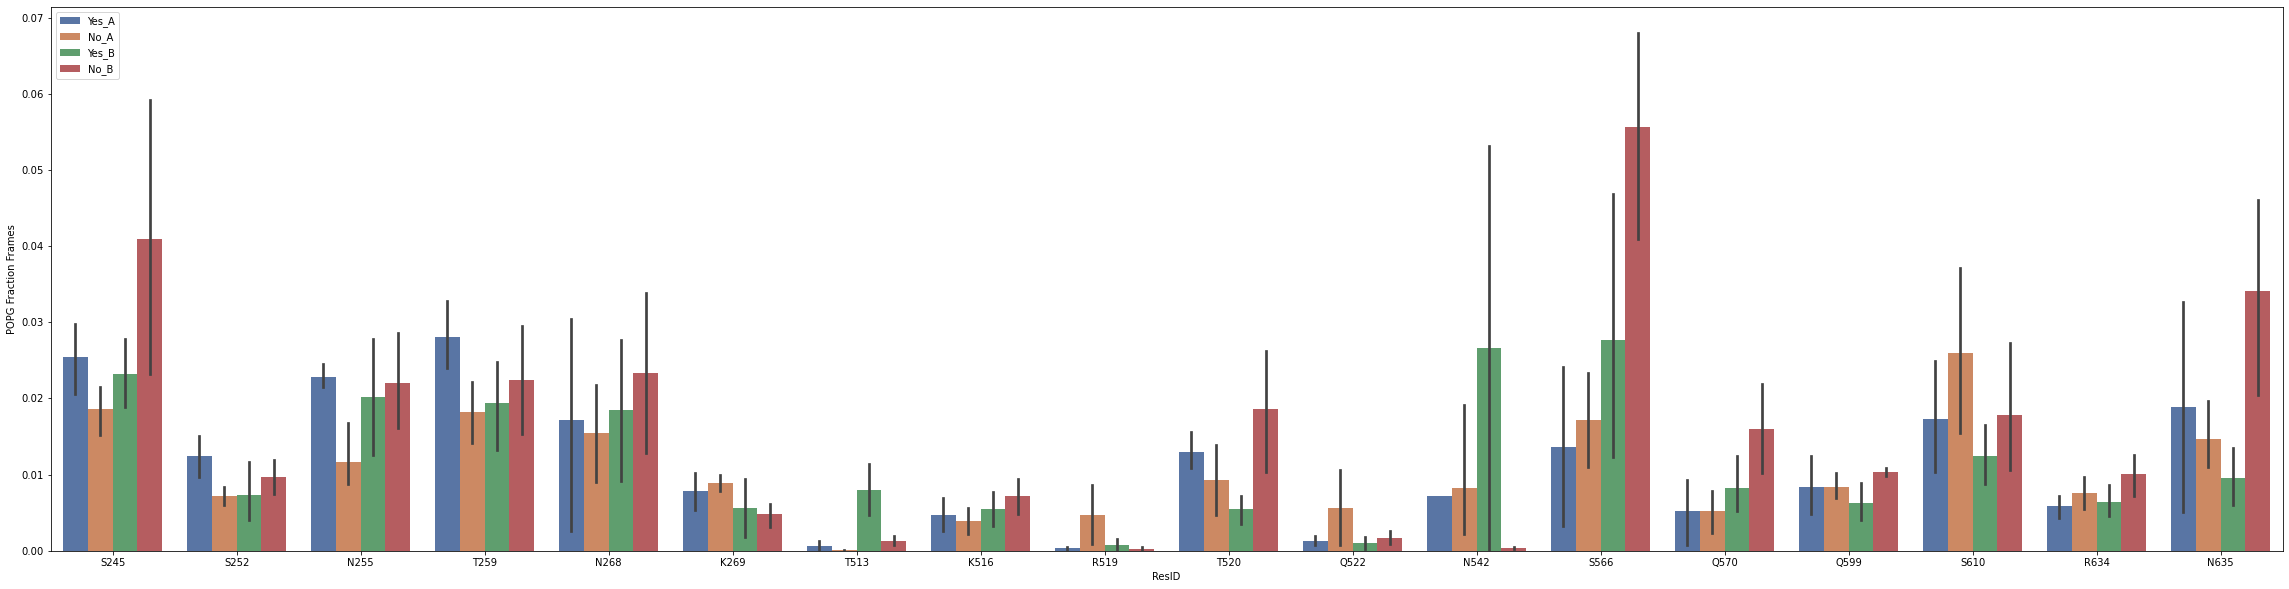

In [27]:
# Plot using seaborn
fig_dims = (40, 10)
fig, ax = plt.subplots(figsize=fig_dims)
melt_group_contact_popg_fig = sns.barplot(x = "Joint_Position", y = "Mean_POPG_Count", 
                                           hue = "Internal_Lipid?_Chain", 
                                           hue_order=["Yes_A","No_A","Yes_B","No_B"], 
                                           data = popg_new, palette=palette_dic, 
                                           estimator=np.mean,ci=90, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("POPG Fraction Frames")
plt.legend(loc='upper left');
melt_group_contact_popg_fig.savefig("Mean POPG Count by Internal Lipid and Chain Relabel Remove.png", dpi = 300)

# Significance Tests for Protein-Lipid Interactions

#### POPE

In [ ]:
# Extract POPE values separating by presence of internal lipid - need full dataset
pope_internal_lip, pope_no_internal_lip = extract_pope_vals(group_contact)

In [ ]:
# Check lengths for bootstrap test partitions
len(pope_internal_lip)

POPE Internal Lipid - 576\
POPE No Internal Lipid - 451

In [ ]:
# Try bootstrap test for POPE internal lipid vs no internal lipid
pooled_pope = list(np.hstack([pope_internal_lip,pope_no_internal_lip]))
n_samples = 200
iterations = 1000000
boot_test_pope = bootstrap_lipid(pooled_pope,n_samples,iterations)

In [ ]:
#Plot bootstrap test histogram 
boot_test = plt.hist(boot_test_pope,bins=100);
plt.title("Substrate Bootstrap Test POPE")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency")
plt.savefig("Substrate Bootstrap Test Histogram POPE", dpi=150)

In [ ]:
# Aggregate data - only separate by presence of internal lipid for pope
group_contact_pope = group_contact.groupby(["Internal_Lipid?","Chain","Protein_ResID","Joint_Position"])["POPE"].mean().unstack()

In [ ]:
#Reset index to remove multi-indexing
group_contact_pope.reset_index(inplace = True)

In [ ]:
# Extract substrate and no substrate values by temp to preserve amino acid and chain position
pope_internal_lip_dic, pope_no_internal_lip_dic = chain_dic_frames_pope(melt_group_contact_pope)

In [ ]:
# Take output of chain_dic_frames() and feed it to chain_pair_vals() to get unique interactions by substrate and temp
diff_lip_pope_dic, unique_lip_pope_dic, unique_no_lip_pope_dic = chain_pair_vals(pope_internal_lip_dic,pope_no_internal_lip_dic)

In [ ]:
#Combine all three dicts to one dictionary
total_diff_pope_dic = {**diff_lip_pope_dic,**unique_lip_pope_dic,**unique_no_lip_pope_dic}

In [ ]:
#Actual distribution of POPE differences
plt.hist(total_diff_pope_dic.values(),bins=100);
plt.title("Actual POPE Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual POPE Differences Internal Lipid vs No Internal Lipid", dpi=150)

In [ ]:
#Calculate p-values using bootstrap test distribution
p_val_pope_boot = p_val(total_diff_pope_dic,iterations,boot_test_pope)

In [ ]:
#Convert p-values to series for saving
p_val_pope_series = pd.Series(p_val_pope_boot, name='p-value')
p_val_pope_series.index.name = "Amino Acid"
p_val_pope_series.reset_index()

In [ ]:
#save p-values!
p_val_pope_series.to_csv('Internal Lipid vs No Internal Lipid POPE p-values bootstrap.csv')

In [ ]:
#Filter for significant p-values 
p_val_pope_sig_boot = sig_p_val(p_val_pope_boot,0.01)

#### Comments

Set of 25 statistically significant (1%) amino acids when for internal lipid vs no internal lipid present based on the bootstrap test:

Chain A:\
N268, S288, Q298, Q441, S442, S446, S447, T520, N542, S566, S591, T597

Chain B:\
S245, S252, N255, S442, S447, N506, T513, T520, N542, T549, S566, Q599, N635

In favour of when internal lipid is present:

Chain A:\
N268, Q298, Q441, S442, S446, S447, T520, S556, T597

Chain B:\
S245, S252, N255, S442, S447, N506, T513, N542, T549, S566, Q599, N635

In favour of when internal lipid is not present:

Chain A:\
S288, N542, S591

Chain B:\
T520

POPE lipid is more enriched when internal lipid present - likely driven by two internal POPE lipid contacts. Results match that of lipid enrichment analysis.

#### CDL2

In [ ]:
# Extract CDL2 values separating by presence of internal lipid - need full dataset
cdl2_internal_lip, cdl2_no_internal_lip = extract_cdl2_vals(group_contact)

In [ ]:
# Check lengths for bootstrap test partitions
len(cdl2_no_internal_lip)

CDL2 Internal Lipid: 576\
CDL2 No Internal Lipid: 451

In [ ]:
# Try bootstrap test for CDL2 internal lipid vs no internal lipid
pooled_cdl2 = list(np.hstack([cdl2_internal_lip,cdl2_no_internal_lip]))
n_samples = 200
iterations = 1000000
boot_test_cdl2 = bootstrap_lipid(pooled_cdl2,n_samples,iterations)

In [ ]:
#Plot bootstrap test histogram 
boot_test = plt.hist(boot_test_cdl2,bins=100);
plt.title("Substrate Bootstrap Test CDL2")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency")
plt.savefig("Substrate Bootstrap Test Histogram CDL2", dpi=150)

In [ ]:
# Aggregate data - only separate by presence of internal lipid for pope
group_contact_cdl2 = group_contact.groupby(["Internal_Lipid?","Chain","Protein_ResID","Joint_Position"])["CDL2"].mean().unstack()

In [ ]:
# Reset index to remove multi-indexing
group_contact_cdl2.reset_index(inplace = True)

In [ ]:
# Extract internal lipid and no internal lipid values to preserve amino acid and chain position
cdl2_internal_lip_dic, cdl2_no_internal_lip_dic = chain_dic_frames_cdl2(melt_group_contact_cdl2)

In [ ]:
# Take output of chain_dic_frames() and feed it to chain_pair_vals() to get unique interactions by substrate and temp
diff_lip_cdl2_dic, unique_lip_cdl2_dic, unique_no_lip_cdl2_dic = chain_pair_vals(cdl2_internal_lip_dic,cdl2_no_internal_lip_dic)

In [ ]:
#Combine all three dicts to one dictionary
total_diff_cdl2_dic = {**diff_lip_cdl2_dic,**unique_lip_cdl2_dic,**unique_no_lip_cdl2_dic}

In [ ]:
#Actual distribution of POPE differences
plt.hist(total_diff_cdl2_dic.values(),bins=100);
plt.title("Actual CDL2 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual CDL2 Differences Internal Lipid vs No Internal Lipid", dpi=150)

In [ ]:
#Calculate p-values using bootstrap test distribution
p_val_cdl2_boot = p_val(total_diff_cdl2_dic,iterations,boot_test_cdl2)

In [ ]:
#Convert p-values to series for saving
p_val_cdl2_series = pd.Series(p_val_cdl2_boot, name='p-value')
p_val_cdl2_series.index.name = "Amino Acid"
p_val_cdl2_series.reset_index()

In [ ]:
#save p-values!
p_val_cdl2_series.to_csv('Internal Lipid vs No Internal Lipid CDL2 p-values bootstrap.csv')

In [ ]:
#Filter for significant p-values 
p_val_cdl2_sig_boot = sig_p_val(p_val_cdl2_boot,0.01)

#### Comments

Set of 23 statistically significant (1%) amino acids when for internal lipid vs no internal lipid present based on the bootstrap test:

Chain A:\
S245, S252, T259, N268, K269, R519, T520, S566, Q570, R634, N635

Chain B:\
S245, S252, N255, T259, R263, N268, T513, K516, T517, S566, S610, N635

In favour of when internal lipid is present:

Chain A:\
K269, T520, R634, N635

Chain B:\
S245, T513, K516, T517, S566, S610

In favour of when internal lipid is not present:

Chain A:\
S245, S252, T259, N268, S566, Q570

Chain B:\
S252, N255, T259, R263, N268, N635

On the whole not much interesting seems to be happening with CDL2 lipid - results match that of lipid enrichment analysis between internal lipid vs no internal lipid.

#### POPG

In [ ]:
# Extract POPG values separating by presence of internal lipid - need full dataset
popg_internal_lip, popg_no_internal_lip = extract_popg_vals(group_contact)

In [ ]:
# Check lengths for bootstrap test partitions
len(popg_internal_lip)

POPG Internal Lipid - 576\
POPG No Internal Lipid - 451\

In [ ]:
# Try bootstrap test for POPG internal lipid vs no internal lipid
pooled_popg = list(np.hstack([popg_internal_lip,popg_no_internal_lip]))
n_samples = 200
iterations = 1000000
boot_test_popg = bootstrap_lipid(pooled_popg,n_samples,iterations)

In [ ]:
#Plot bootstrap test histogram 
boot_test = plt.hist(boot_test_popg,bins=100);
plt.title("Substrate Bootstrap Test POPG")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency")
plt.savefig("Substrate Bootstrap Test Histogram POPG", dpi=150)

In [ ]:
# Aggregate data - only separate by presence of internal lipid for pope
group_contact_popg = group_contact.groupby(["Internal_Lipid?","Chain","Protein_ResID","Joint_Position"])["POPG"].mean().unstack()

In [ ]:
#Reset index to remove multi-indexing
group_contact_popg.reset_index(inplace = True)

In [ ]:
# Extract internal lipid and no internal lipid values to preserve amino acid and chain position
popg_internal_lip_dic, popg_no_internal_lip_dic = chain_dic_frames_popg(melt_group_contact_popg)

In [ ]:
# Take output of chain_dic_frames() and feed it to chain_pair_vals() to get unique interactions by substrate and temp
diff_lip_popg_dic, unique_lip_popg_dic, unique_no_lip_popg_dic = chain_pair_vals(popg_internal_lip_dic,popg_no_internal_lip_dic)

In [ ]:
#Combine all three dicts to one dictionary
total_diff_popg_dic = {**diff_lip_popg_dic,**unique_lip_popg_dic,**unique_no_lip_popg_dic}

In [ ]:
#Actual distribution of POPG differences
plt.hist(total_diff_popg_dic.values(),bins=100);
plt.title("Actual POPG Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual POPG Differences Internal Lipid vs No Internal Lipid", dpi=150)

In [ ]:
#Calculate p-values using bootstrap test distribution
p_val_popg_boot = p_val(total_diff_popg_dic,iterations,boot_test_popg)

In [ ]:
#Convert p-values to series for saving
p_val_popg_series = pd.Series(p_val_popg_boot, name='p-value')
p_val_popg_series.index.name = "Amino Acid"
p_val_popg_series.reset_index()

In [ ]:
#save p-values!
p_val_popg_series.to_csv('Internal Lipid vs No Internal Lipid POPG p-values bootstrap.csv')

In [ ]:
#Filter for significant p-values 
p_val_popg_sig_boot = sig_p_val(p_val_popg_boot,0.01)

#### Comments

Set of 22 statistically significant (1%) amino acids when for internal lipid vs no internal lipid present based on the bootstrap test:

Chain A:\
S245, S252, N255, T259, R519, T520, Q522, N542, S566, S610, N635

Chain B:\
S245, N268, T513, T520, N542, S566, Q570, Q599, S610, R634, N635

In favour of when internal lipid is present:

Chain A:\
S245, S252, N255, T259, T520, N635

Chain B:\
T513, N542

In favour of when internal lipid is not present:

Chain A:\
R519, Q522, N542, S566, S610

Chain B:\
S245, N268, T520, S566, Q570, Q599, S610, R634, N635

There might be something interesting with the POPG results - slightly more POPG interactions in Chain B when there is no internal lipid.


### Cavity Estimation

In [ ]:
# import dfs - internal lipid cavity estimates
cavity_internal_lip_traj_1 = pd.read_csv("data/mean_cavity_distance_internal_lipid_traj_1.csv")
cavity_internal_lip_traj_2 = pd.read_csv("data/mean_cavity_distance_internal_lipid_traj_2.csv")
cavity_internal_lip_traj_3 = pd.read_csv("data/mean_cavity_distance_internal_lipid_traj_3.csv")
cavity_internal_lip_traj_4 = pd.read_csv("data/mean_cavity_distance_internal_lipid_traj_4.csv")
cavity_internal_lip_traj_5 = pd.read_csv("data/mean_cavity_distance_internal_lipid_traj_5.csv")

In [ ]:
# import dfs - no internal lipid cavity estimates
cavity_no_internal_lip_traj_1 = pd.read_csv("data/mean_cavity_distance_no_internal_lipid_traj_1.csv")
cavity_no_internal_lip_traj_2 = pd.read_csv("data/mean_cavity_distance_no_internal_lipid_traj_2.csv")
cavity_no_internal_lip_traj_3 = pd.read_csv("data/mean_cavity_distance_no_internal_lipid_traj_3.csv")
cavity_no_internal_lip_traj_4 = pd.read_csv("data/mean_cavity_distance_no_internal_lipid_traj_4.csv")
cavity_no_internal_lip_traj_5 = pd.read_csv("data/mean_cavity_distance_no_internal_lipid_traj_5.csv")

In [ ]:
# Concat trajectory repeats - by internal lipid
cavity_internal_lipid = pd.concat([cavity_internal_lip_traj_1,cavity_internal_lip_traj_2,
                                   cavity_internal_lip_traj_3,cavity_internal_lip_traj_4,
                                   cavity_internal_lip_traj_5]).groupby('Time (ns)').agg(avg=('Mean Distance','mean'), std=('Mean Distance','std'))

In [ ]:
# Concat trajectory repeats - by no internal lipid
cavity_no_internal_lipid = pd.concat([cavity_no_internal_lip_traj_1,
                                      cavity_no_internal_lip_traj_2,
                                      cavity_no_internal_lip_traj_3,
                                      cavity_no_internal_lip_traj_4,
                                      cavity_no_internal_lip_traj_5]).groupby('Time (ns)').agg(avg=('Mean Distance','mean'), std=('Mean Distance','std'))

In [ ]:
#Reset index to remove multi-indexing
cavity_internal_lipid.reset_index(inplace = True)
cavity_no_internal_lipid.reset_index(inplace = True)

In [ ]:
# Plot cavity estimation
plt.errorbar(x=cavity_internal_lipid["Time (ns)"],y=cavity_internal_lipid["avg"],yerr=cavity_internal_lipid["std"],label="Internal Lipid")
plt.errorbar(x=cavity_no_internal_lipid["Time (ns)"],y=cavity_no_internal_lipid["avg"],yerr=cavity_no_internal_lipid["std"],label="No Internal Lipid")
plt.legend(loc='best')
plt.title("Cavity Estimation")
plt.xlabel("Time (ns)")
plt.ylabel("Average Mean Distance (Angstrom)")
plt.savefig("Cavity Estimation Internal Lipid vs No Internal Lipid", dpi=300)

In [ ]:
# Calulate rolling average
cavity_internal_lipid_rolling = cavity_internal_lipid["avg"].rolling(window=1000,center=True).mean()
cavity_no_internal_lipid_rolling = cavity_no_internal_lipid["avg"].rolling(window=1000,center=True).mean()

In [ ]:
# Plot results
plt.plot(cavity_internal_lipid["avg"], label="Internal Lipid")
plt.plot(cavity_internal_lipid_rolling, label="Internal Lipid Rolling Average")
plt.plot(cavity_no_internal_lipid["avg"], label="No Internal Lipid")
plt.plot(cavity_no_internal_lipid_rolling, label="No Internal Lipid Rolling Average")
plt.legend(loc='best')

In [ ]:
# Plot results without label
plt.errorbar(x=cavity_internal_lipid["Time (ns)"],y=cavity_internal_lipid["avg"],yerr=cavity_internal_lipid["std"],label="Internal Lipid")
plt.errorbar(x=cavity_no_internal_lipid["Time (ns)"],y=cavity_no_internal_lipid["avg"],yerr=cavity_no_internal_lipid["std"],label="No Internal Lipid")
plt.errorbar(x=cavity_internal_lipid["Time (ns)"],y=cavity_internal_lipid_rolling)
plt.errorbar(x=cavity_no_internal_lipid["Time (ns)"],y=cavity_no_internal_lipid_rolling)
plt.legend(loc='best')
plt.title("Cavity Estimation")
plt.xlabel("Time (ns)")
plt.ylabel("Average Mean Distance (Angstrom)")
plt.savefig("Cavity Estimation Internal Lipid vs No Internal Lipid Rolling Average no label", dpi=300)